<a href="https://colab.research.google.com/github/matinmoezzi/MyCobotGym/blob/main/day7_pm_afternoon/D7_A_Monte_Carlo_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Importing packages and initializing the environment

In [1]:
!apt-get install -y xvfb x11-utils 2> /dev/null
%pip install pyvirtualdisplay 2> /dev/null
%pip install piglet 2> /dev/null

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# Set up virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

In the `gym` library, the `render()` function is used to visualize the environment.

The `render()` function typically has a parameter called `render_mode`, which specifies the form in which the environment should be visualized. Different environments can have different rendering modes.

Some common `render_mode` options include:

1. **'human'**:
   - This mode displays the environment in a human-friendly manner, often popping up a window for visualization. For many standard environments like `CartPole` or `MountainCar`, using this mode will open a window where you can visually see the agent interact with the environment.

2. **'rgb_array'**:
   - This mode returns an RGB array representing a visualization of the environment, which can be useful for recording videos or further processing.

3. **'ansi'**:
   - This mode is less common and is mainly for text-based environments. It returns a string-based representation of the environment's state, which can then be printed to the console.

Not all environments will support all modes, and some environments might have additional, specialized rendering modes. Always check the specific `gym` environment's documentation or code to see which render modes are supported.

In general, if you're working with an environment and you're unsure of how it will render or which modes it supports, it's a good practice to start with `render_mode='human'` to get a visual sense of the environment.

### Dense Reward Wrapper:
Wrappers are a convenient way to modify an existing environment without having to alter the underlying code directly. Using wrappers will allow you to avoid a lot of boilerplate code and make your environment more modular. Wrappers can also be chained to combine their effects. Most environments that are generated via gym.make will already be wrapped by default.

If you would like to apply a function to the reward that is returned by the base environment before passing it to learning code, you can simply inherit from RewardWrapper and overwrite the method reward to implement that transformation.

In order to get meaningful plots from Monte Carlo methods, we make the reward function more dense (no longer sparse) such that:
- Reach holes: -10
- Reach goal: +1
- Otherwise: -1 (To penalize spending time)

In [3]:
class DenseReward(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.done = done
        return observation, self.reward(reward), done, info

    def reward(self, reward):
        if reward == 0:
          if self.done:
            return -10
          return -1
        else:
          return 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)
env = DenseReward(env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Step 2: Generating Episode:

Generate one episode of the environment under the given policy.



In [5]:
def generate_episode(env, policy, num_steps=20, render=False, render_mode="ansi"):
  steps = []
  state = env.reset()
  for _ in range(num_steps):
    probs= [policy[state, a] for a in range(env.action_space.n)]
    action = np.random.choice(np.arange(env.action_space.n), p=probs)
    next_state, reward, done, info = env.step(action)
    if render:
      if render_mode == "ansi":
        print(*env.render())
      elif render_mode == "rgb_array":
        ipythondisplay.clear_output(wait=True)
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')
        plt.show()
        ipythondisplay.display(plt.gcf())
      else:
        raise NotImplementedError()

    steps.append((state, action, reward))
    state = next_state
    if done:
      break
  return steps

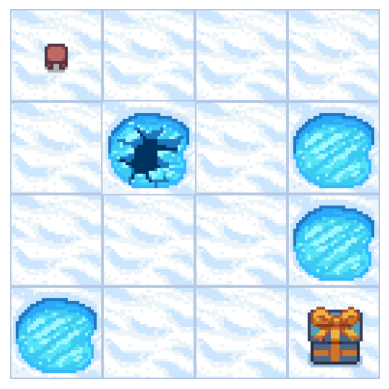

<Figure size 640x480 with 0 Axes>

[(0, 0, -1), (0, 3, -1), (0, 1, -1), (4, 2, -10)]

<Figure size 640x480 with 0 Axes>

In [6]:
policy = np.full((16,4),0.25)
generate_episode(env, policy, render=True, render_mode="rgb_array")

## Step 3: On-policy every-visit Monte Carlo Implementation

### 3.1 Every visit Monte Carlo prediction

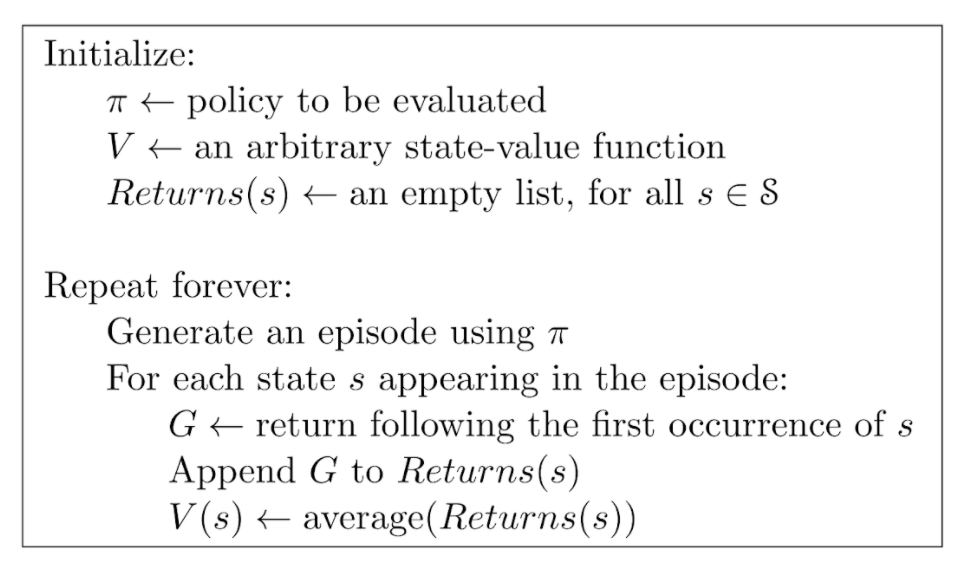

In [7]:
def every_visit_mc_prediction(policy, episode_n, gamma, env):
    #initialize
    V = np.zeros(env.observation_space.n)
    returns = [[] for _ in range(env.observation_space.n)]
    V_hist = np.zeros((episode_n, 16))

    for i in trange(episode_n):
        episode = generate_episode(env, policy, render=False)
        G = 0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = gamma * G + reward
            returns[state].append(G)
            V[state] = np.average(returns[state])
        V_hist[i,:] = V.copy()
    return V, V_hist


In [8]:
policy= 1/4 * np.ones((16,4))
V, V_hist = every_visit_mc_prediction(policy, 2000, 0.99, env)

  0%|          | 0/2000 [00:00<?, ?it/s]

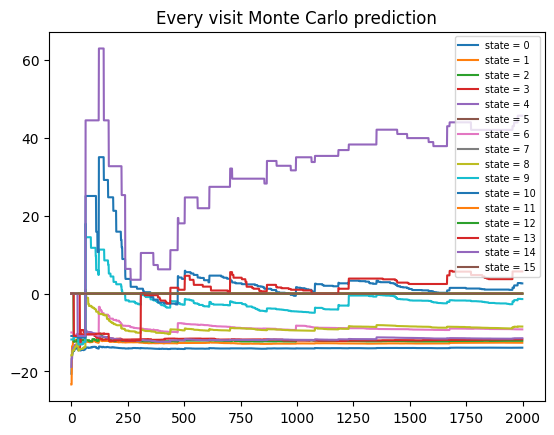

In [9]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.title("Every visit Monte Carlo prediction")

plt.show()

In [10]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))

╒════════════╤════════════╤════════════╤════════════╕
│ S -13.91   │ F -12.64   │ F -12.14   │ F -11.75   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -11.48   │ H 0.0      │ F -9.2     │ F 0.0      │
├────────────┼────────────┼────────────┼────────────┤
│ F -8.48    │ F -1.4     │ F 2.63     │ F 0.0      │
├────────────┼────────────┼────────────┼────────────┤
│ H 0.0      │ F 5.7      │ F 45.75    │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛


### Exercise 1:

Implement first-visit Monte Carlo Prediction. Plot the value functions history.
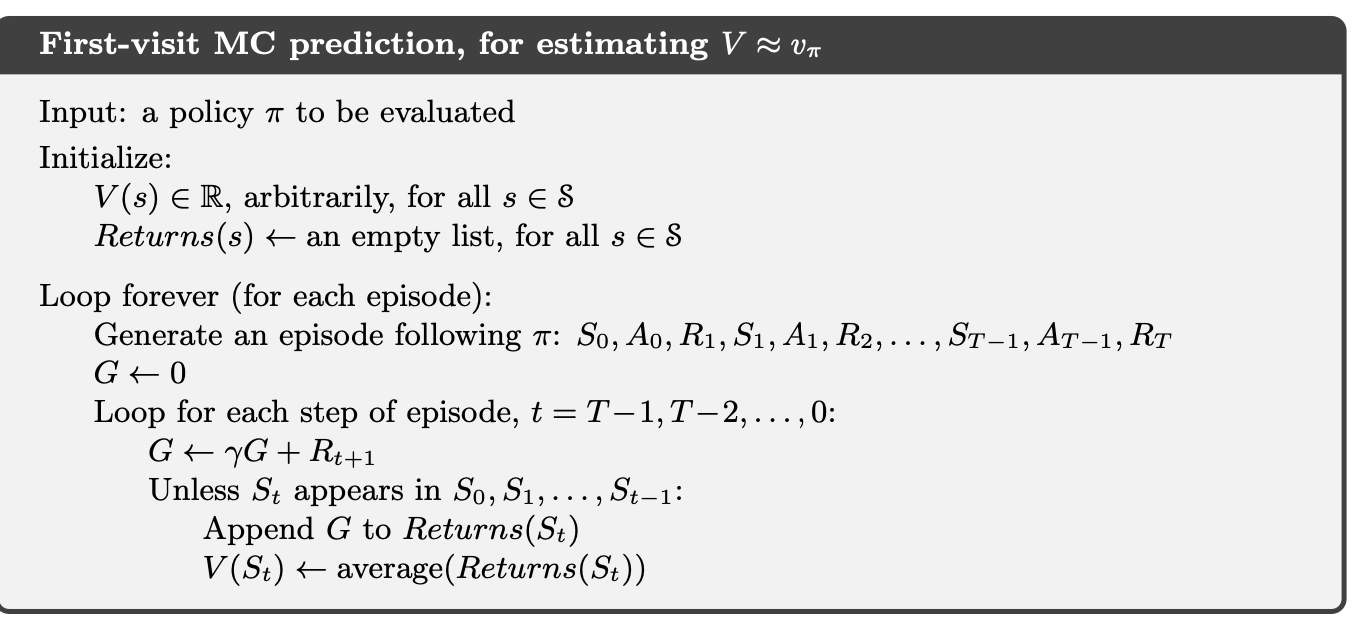

### 3.2 First-visit Monte Carlo Prediction

In [11]:
def first_visit_mc_prediction(policy, episode_n, gamma, env):
    #initialize
    V = np.zeros(env.observation_space.n)
    returns = [[] for _ in range(env.observation_space.n)]
    V_hist = np.zeros((10000, 16))

    for i in trange(episode_n):
        episode = generate_episode(env, policy, render=False)
        G = 0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            if (state, action) not in [(sar[0], sar[1]) for sar in episode[:len(episode)-t-1]]:
                G = gamma * G + reward
                returns[state].append(G)
                V[state] = np.average(returns[state])
        V_hist[i,:] = V.copy()
    return V, V_hist

In [12]:
policy= 1/4 * np.ones((16,4))
V, V_hist = first_visit_mc_prediction(policy, 5000, 0.99, env)

  0%|          | 0/5000 [00:00<?, ?it/s]

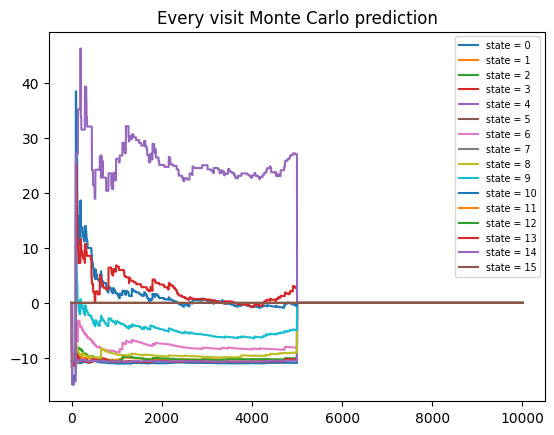

In [13]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.title("Every visit Monte Carlo prediction")

plt.show()

In [14]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))

╒════════════╤════════════╤════════════╤════════════╕
│ S -10.91   │ F -10.36   │ F -10.09   │ F -10.22   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -10.5    │ H 0.0      │ F -8.14    │ F 0.0      │
├────────────┼────────────┼────────────┼────────────┤
│ F -9.06    │ F -4.98    │ F -0.53    │ F 0.0      │
├────────────┼────────────┼────────────┼────────────┤
│ H 0.0      │ F 2.69     │ F 27.03    │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛


### 3.3 Every-visit Monte Carlo Control

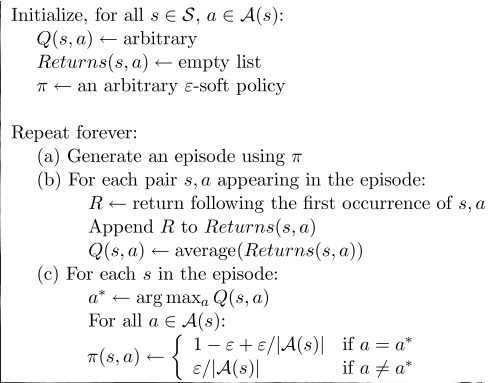

In [15]:
def every_visit_MC(env, num_episodes, gamma=0.9, epsilon=0.3):

    # Initializtion
    undiscounted_returns = []
    policy = np.ones((env.observation_space.n, env.action_space.n)) * (1/env.action_space.n)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    Returns = [[[] for j in range(env.action_space.n)] for i in range(env.observation_space.n)]

    for i in tqdm(range(num_episodes)):
        episode = generate_episode(env, policy, render=False)
        G = 0
        undis_return = 0
        for state, action, reward in episode[::-1]:
           G = gamma * G + reward
           undis_return += reward
           Returns[state][action].append(G)
           Q[state, action] = np.mean(Returns[state][action])
           a_max = np.argmax(Q[state])
           for a in range(env.action_space.n):
                if (a != a_max):
                    policy[state, a] = epsilon / env.action_space.n
                else:
                    policy[state, a]  = 1.0 - epsilon + epsilon/env.action_space.n
        undiscounted_returns.append(undis_return)
    return policy, undiscounted_returns

In [36]:
num_episodes = 2000
ev_MC_policy, ev_MC_returns = every_visit_MC(env, num_episodes)

  0%|          | 0/2000 [00:00<?, ?it/s]

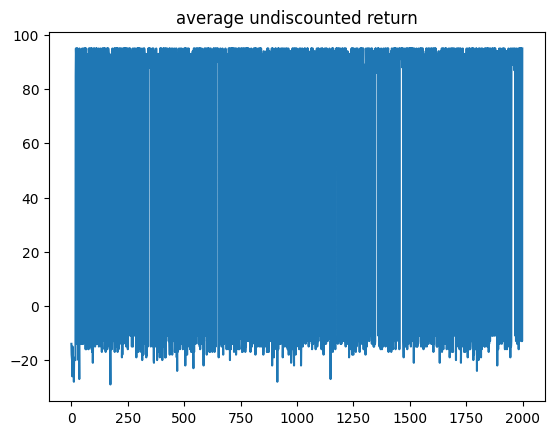

In [37]:
plt.plot(ev_MC_returns)
plt.title(f"average undiscounted return")

plt.show()

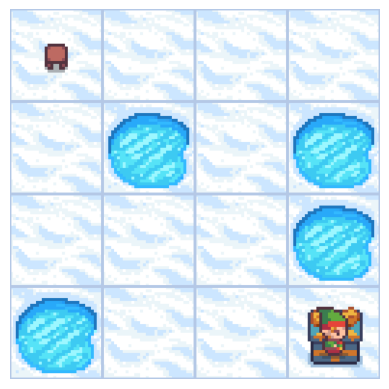

<Figure size 640x480 with 0 Axes>

[(0, 2, -1),
 (1, 3, -1),
 (1, 0, -1),
 (0, 2, -1),
 (1, 2, -1),
 (2, 1, -1),
 (6, 1, -1),
 (10, 1, -1),
 (14, 0, -1),
 (13, 2, -1),
 (14, 2, 100)]

<Figure size 640x480 with 0 Axes>

In [40]:
generate_episode(env, ev_MC_policy, render=True, render_mode='rgb_array')

### Exercise 2:

Implement on-policy first-visit Monte Carlo algorithm.

### On-poliyc first-visit MC

In [41]:
def first_visit_MC(episodes_n = 2000, env = env, gamma = 0.9, epsilon = 0.3):

    # Initializtion
    undiscounted_returns = []
    policy = np.full((env.observation_space.n,env.action_space.n),1/env.action_space.n)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    Returns = [[[] for j in range(env.action_space.n)] for i in range(env.observation_space.n)]

    for i in tqdm(range(episodes_n)):
        episode = generate_episode(env, policy)
        G = 0
        undis_return = 0
        for t, (state, action, reward) in enumerate(episode[::-1]):
            if (state, action) not in [(sar[0], sar[1]) for sar in episode[:len(episode)-t-1]]:
                G = gamma * G + reward
                undis_return += reward
                Returns[state][action].append(G)
                Q[state, action] = np.mean(Returns[state][action])
                a_max = np.argmax(Q[state])
                for a in range(env.action_space.n):
                    if (a != a_max):
                        policy[state, a] = epsilon / env.action_space.n
                    else:
                        policy[state, a]  = 1.0 - epsilon + epsilon/env.action_space.n
        undiscounted_returns.append(undis_return)
    return policy, undiscounted_returns

In [42]:
num_episodes = 5000
fv_MC_policy, fv_MC_returns = first_visit_MC(num_episodes, env)

  0%|          | 0/5000 [00:00<?, ?it/s]

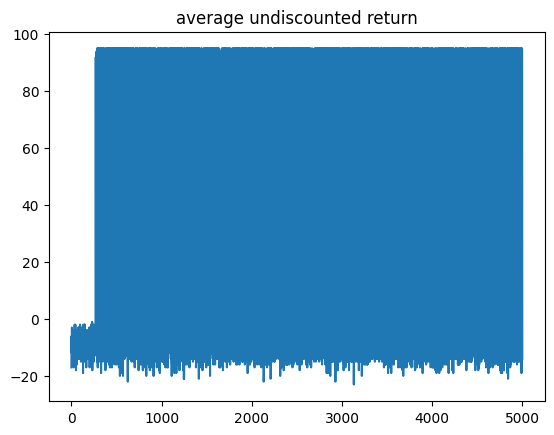

In [43]:
plt.plot(fv_MC_returns)
plt.title("average undiscounted return")

plt.show()

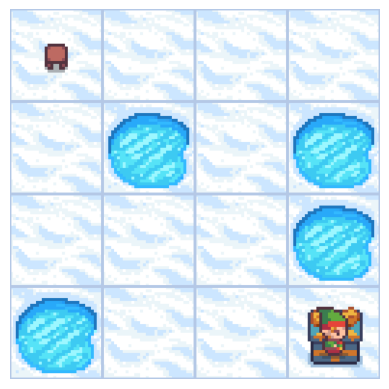

<Figure size 640x480 with 0 Axes>

[(0, 1, -1), (4, 1, -1), (8, 2, -1), (9, 1, -1), (13, 2, -1), (14, 2, 100)]

<Figure size 640x480 with 0 Axes>

In [46]:
generate_episode(env, fv_MC_policy, render=True, render_mode="rgb_array")

## Off-policy Ordinary MC

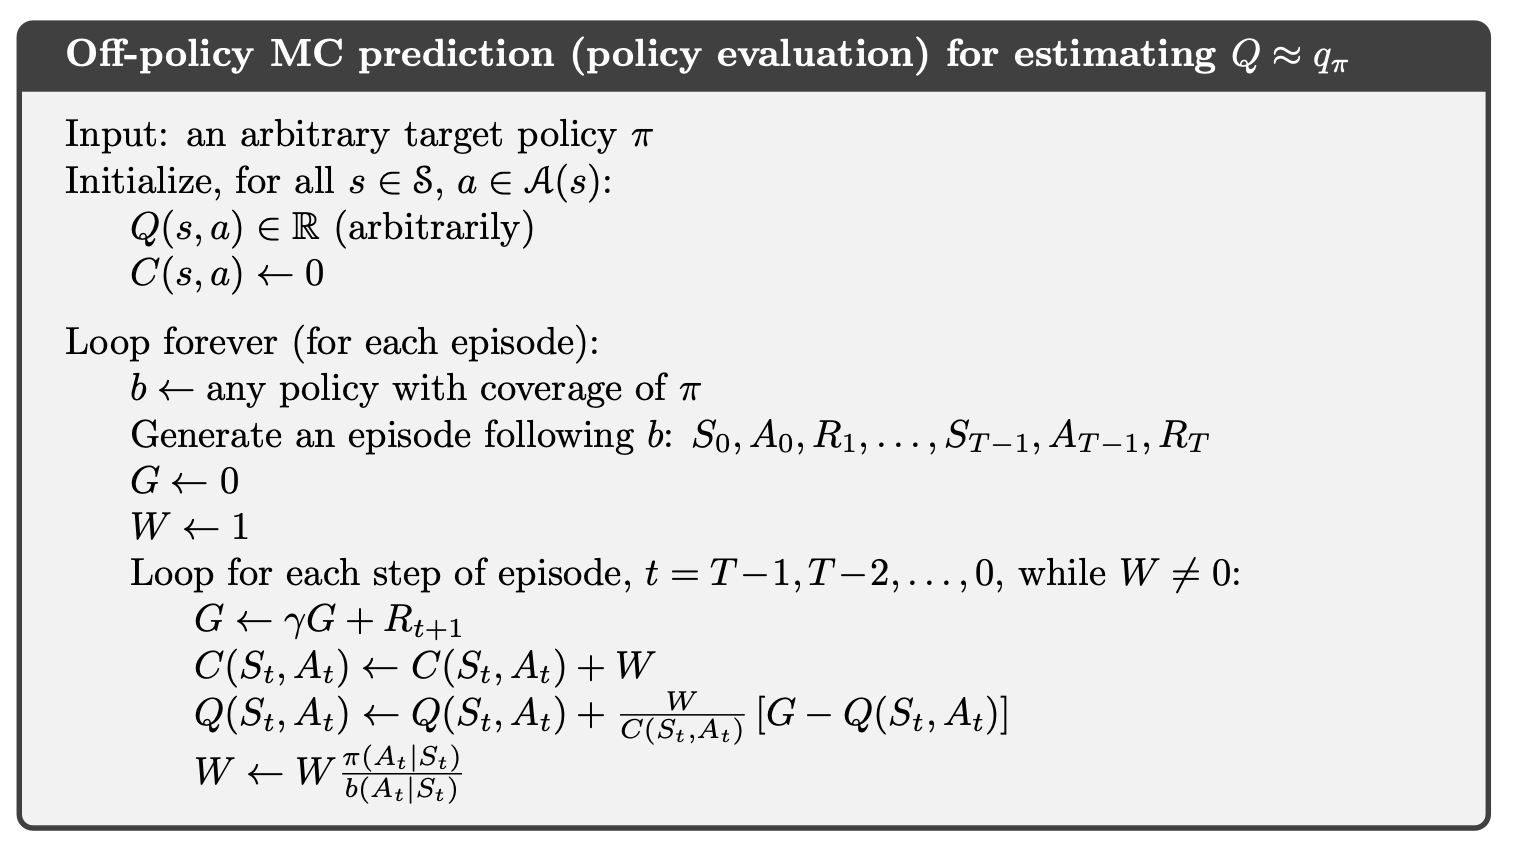

In [47]:
# Behavior Policy
b = np.ones((env.observation_space.n,env.action_space.n)) * (1/env.action_space.n)

In [48]:
def ordinary_IS_MC(env, behavior_policy, target_policy, num_episodes, gamma):
    V = np.zeros(env.observation_space.n)
    C = np.zeros((env.observation_space.n, env.action_space.n))
    V_hist = np.zeros((num_episodes, env.observation_space.n))
    for i in range(num_episodes):
        episode = generate_episode(env, behavior_policy, render=False)
        G = 0.0
        W = 1.0
        for t, (state, action, reward) in enumerate(episode):
            G = gamma * G + reward
            C[state,action] += 1
            V[state] += (W/C[state,action]) * (G - V[state])
            W *= target_policy[state,action]/behavior_policy[state,action]
            if W == 0:
                break
        V_hist[i] = V.copy()
    return V, V_hist


In [55]:
def v_s(s):
  V_hist_ordinary_s = np.zeros((1, 2000))
  for i in range(1):
    V_ordinary, V_hist_ordinary = ordinary_IS_MC(env, ev_MC_policy, b, 2000, 0.99)
    V_hist_ordinary_s [i,:] = V_hist_ordinary[:,s]

  return V_hist_ordinary_s

In [56]:
def plot_many(experiments, label, color):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
        mean_exp - std_exp, color=color, alpha=0.1)

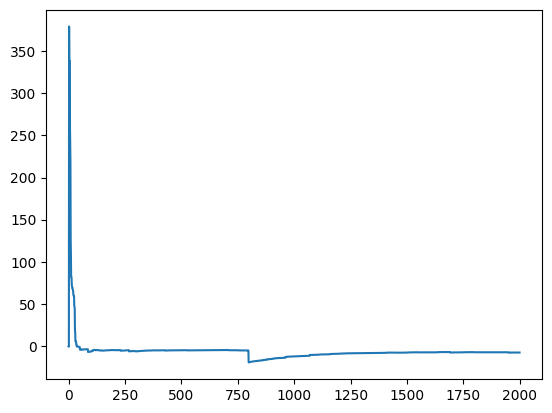

In [57]:
V_hist_s_0_ordinary = v_s(1)
plot_many(V_hist_s_0_ordinary, "ordinary", None)

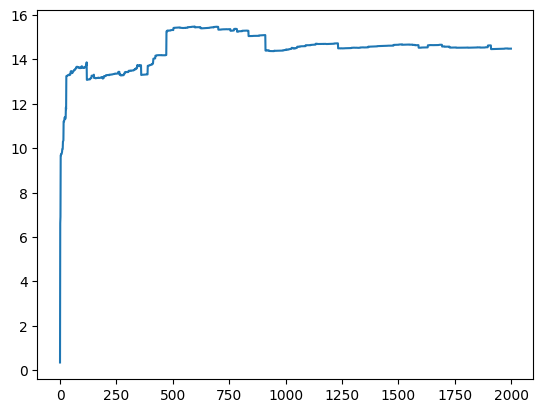

In [58]:
V_hist_s_0_ordinary = v_s(14)
plot_many(V_hist_s_0_ordinary, "ordinary", None)

### Exercise 3:

Implement Monte Carlo methods for FrozenLake with `is_slippery=True`